In [1]:
import cv2
import osgeo.osr
import matplotlib.pyplot as plt
import numpy as np
import skimage
import pandas as pd

import skimage.draw
from scipy import ndimage as ndi
import xarray as xr
import matplotlib.dates
import matplotlib.gridspec

import tqdm

%matplotlib inline

In [2]:
t_start = '2016-11-19'
t_end = '2021-11-18'
dates = pd.date_range(t_start, t_end, 151)

# Source  of  mass change
# Groh, A., & Horwath, M. (2021). Antarctic Ice Mass Change Products from GRACE/GRACE-FO Using Tailored Sensitivity Kernels. Remote Sens., 13(9), 1736. doi:10.3390/rs13091736

In [3]:
geometry = {
    "type": "Polygon", 
    "coordinates": [
        [
            [-104.4976510688806, -72.6030767076305],
            [-106.99313405753333, -72.57067131368113],
            [-109.4833626490581, -72.68093485836563],
            [-111.1046921412843, -72.95258423388972],
            [-112.30890686560303, -73.36398023356362],
            [-113.73382469923513, -74.0031362469669],
            [-114.3712827842066, -74.91255624033003],
            [-112.90366105407264, -75.77650886089448],
            [-109.04988417819868, -76.11591410465728],
            [-103.79747121596155, -76.13043139939217],
            [-98.42963110080359, -76.04115494234634],
            [-95.80149593276303, -75.72714057150225],
            [-94.90208485074777, -75.00837080648952],
            [-95.3330057147159, -74.13175522025747],
            [-97.37942795402, -73.61836770317167],
            [-100.77906307057117, -73.11804758217465],
            [-102.70234535614323, -72.74610128241353]
        ]
    ]
}


bounds = {
  "type": "Polygon",
  "coordinates": [
    [
      [
        -114.37128278420661,
        -76.1381262601676
      ],
      [
        -94.90208485074778,
        -76.1381262601676
      ],
      [
        -94.90208485074778,
        -72.5706713136811
      ],
      [
        -114.37128278420661,
        -72.5706713136811
      ],
      [
        -114.37128278420661,
        -76.1381262601676
      ]
    ]
  ]
}


background_geometry = {
   "type": "Polygon",
  "coordinates": [
    [
      [
        -116.9115,
        -77.2492
      ],
      [
        -94.6915,
        -77.2492
      ],
      [
        -94.6915,
        -71.2983
      ],
      [
        -116.9115,
        -71.2983
      ],
      [
        -116.9115,
        -77.2492
      ]
    ]
  ]
   
}

zoom_out_url = 'https://storage.googleapis.com/deltares-video-map/optical-flow-test-4kee-export-video4615086394714517360.mp4'
pine_url = 'https://storage.googleapis.com/deltares-video-map/pine-4kee-export-video6165949304479669766.mp4'
thwaites_url = 'https://storage.googleapis.com/deltares-video-map/thwaites-4kee-export-video7758716053102911319.mp4'


In [4]:
# define projection sytem
wgs = osgeo.osr.SpatialReference()
wgs.ImportFromEPSG(4326)

#  maybe something more local?
web = osgeo.osr.SpatialReference()
web.ImportFromEPSG(3857)
wgs2web = osgeo.osr.CoordinateTransformation(wgs, web)

In [5]:
# convert to coor
bounds_web = wgs2web.TransformPoints([(lat, lon) for (lon, lat) in bounds['coordinates'][0]])
geometry_web = wgs2web.TransformPoints([(lat, lon) for (lon, lat) in geometry['coordinates'][0]])
background_web = wgs2web.TransformPoints([(lat, lon) for (lon, lat) in background_geometry['coordinates'][0]])
bounds_web = np.array(bounds_web)
geometry_web = np.array(geometry_web)
background_web = np.array(background_web)

In [6]:
ll = bounds_web[0][:2]
ur = bounds_web[2][:2]
ll, ur

ll_wgs = bounds['coordinates'][0][0]
ur_wgs = bounds['coordinates'][0][2]
ll_wgs, ur_wgs

ll_background = background_web[0][:2]
ur_background = background_web[2][:2]
ll, ur


(array([-12731752.96091138, -13440887.4174572 ]),
 array([-10564451.76080529, -11961982.11411704]))

In [7]:
extent = (ll[0], ur[0], ll[1], ur[1])
extent_background = (ll_background[0], ur_background[0], ll_background[1], ur_background[1])



In [8]:
caps = {}
caps['zoom'] = cv2.VideoCapture(zoom_out_url)
caps['pine'] = cv2.VideoCapture(pine_url)
caps['thwaites'] = cv2.VideoCapture(thwaites_url)

def iter_images():
    for i in range(200):
        imgs = {}
        for key, cap in caps.items():
            status, img_bgr = cap.read()
            # as soon as first capture is empty, we're done
            if not status:
                break
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGBA)
            img_rgb_float = skimage.img_as_float(img_rgb)
            imgs[key] = img_rgb_float
        # we're done
        if not status:
            break
        yield imgs


# get the first image for each location
imgs = next(iter_images())

# Mask
Here we make semi-transparent mark to denote the region of interest

In [9]:
mask = np.zeros_like(imgs['zoom'][..., 0], dtype='float32')
width, height = mask.shape
geometry_px = np.zeros_like(geometry_web)

# huh.... something is going wrong here...
geometry_px[:, 0] = (1 - (geometry_web[:, 1] - ll[1]) / (ur[1] - ll[1])) * width
geometry_px[:, 1] = (geometry_web[:, 0] - ll[0]) / (ur[0] - ll[0]) * height

mask = skimage.draw.polygon2mask(mask.shape, geometry_px[:, :2])
mask = mask.astype('float32')
blurred_mask = ndi.gaussian_filter(mask, sigma=10)
blurred_mask = np.maximum(blurred_mask, mask)


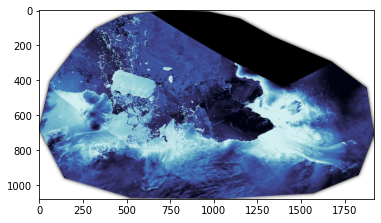

In [10]:
# test  it on the  zoomed  image
imgs['zoom'][..., 3] = blurred_mask 
plt.imshow(imgs['zoom'])

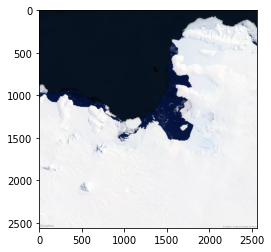

In [11]:
# you can get the background like this, you do  need  a mapbox token
token = ''
background_url = f'https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/[{ll_wgs[0]},{ll_wgs[1]},{ur_wgs[0]},{ur_wgs[1]}]/{height // 2}x{width // 2}@2x?access_token={token}'
# extracted and saved
background = plt.imread('../../../data/mapbox/thwaites.jpg')
plt.imshow(background)


In [12]:
regions = {
    b'AIS21': 'Thwaites',
    b'AIS22': 'Pine'
}
with xr.open_dataset('../../../data/tudresden/AIS_GMB_basin.nc') as ds:
    region_idx = np.isin(ds.regions, [b'AIS21', b'AIS22'])
    t = ds.time

    kg2Gt = 1/1000000000000.0
    mass = ds.dm[region_idx, :] 
    regions = ds.regions[region_idx]
    # in kg / day
    mass_diff = np.diff(mass) / np.diff(t).astype('timedelta64[D]').astype('float32')
    
regions

<xarray.DataArray 'regions' (reg: 2)>
array([b'AIS21', b'AIS22'], dtype='|S5')
Dimensions without coordinates: reg
Attributes:
    long_name:  regions of the Antarctic Ice Sheet

((1000, 1000, 4), (1000, 1000, 4))

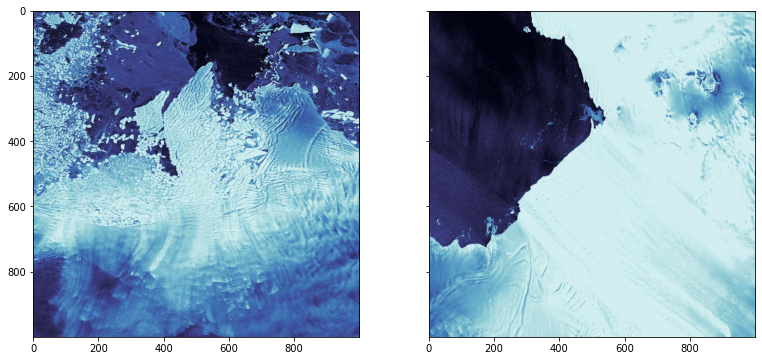

In [13]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(13, 6))
thwaites_slice = (slice(80, None), slice(520, -400))
pine_slice = (slice(500, -420), slice(None, -80))


axes[0].imshow(imgs['thwaites'][thwaites_slice])
axes[1].imshow(imgs['pine'][pine_slice])

imgs['thwaites'][thwaites_slice].shape, imgs['pine'][pine_slice].shape

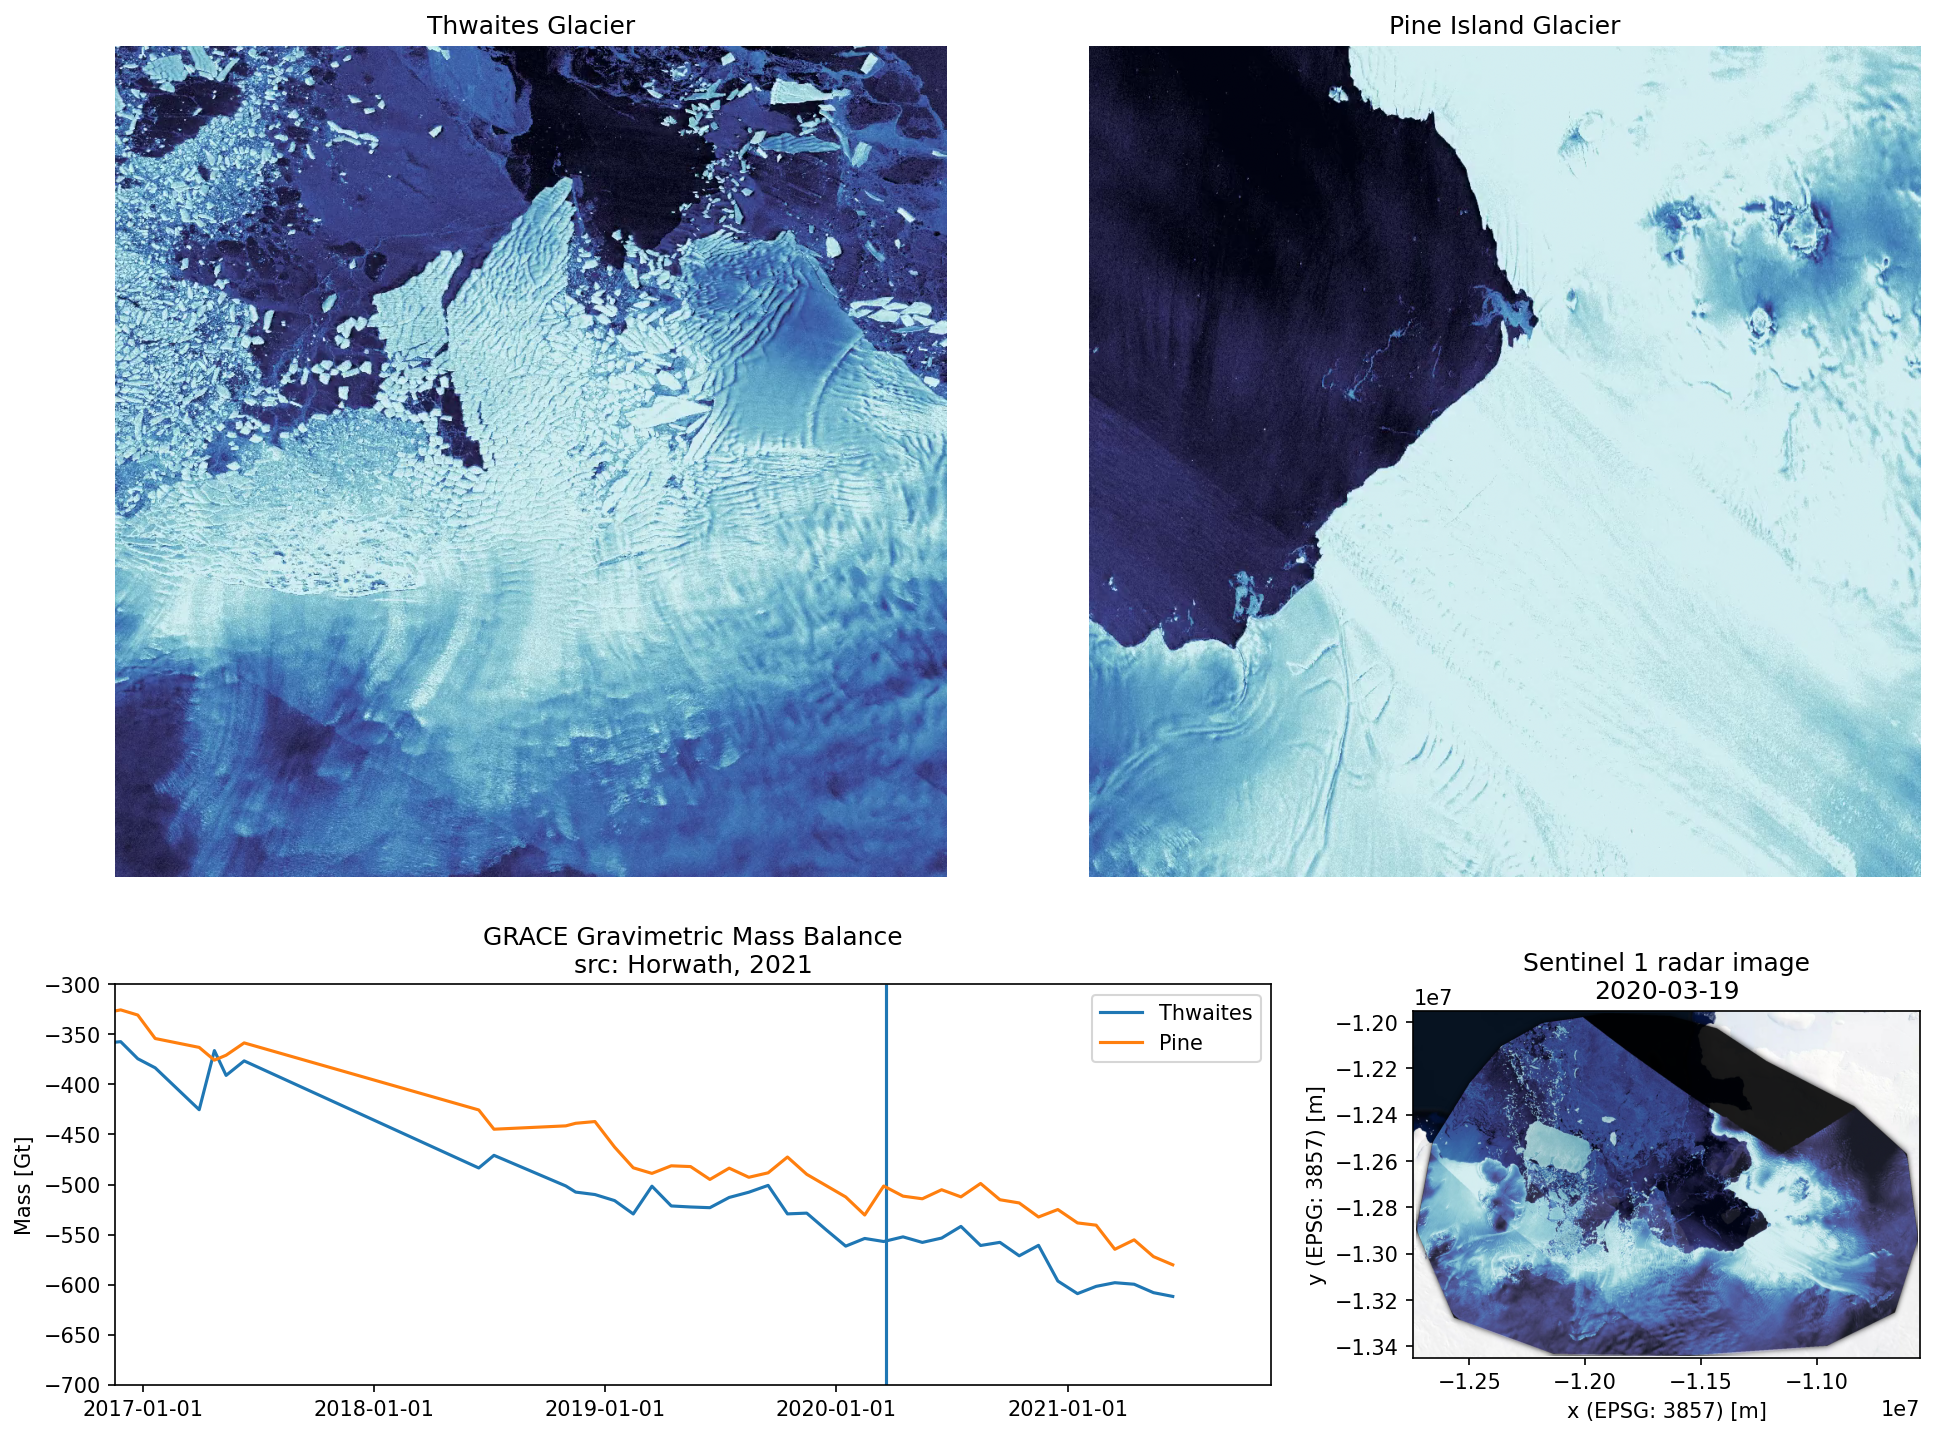

In [14]:
def plot_timestep(i, imgs):
    date = dates[i]
    # blur the zoom image
    imgs['zoom'][..., 3] = blurred_mask 

    # just create  the whole plot
    # updating is faster but also more administration
    fig =  plt.figure(figsize=(13, 10), dpi=150)

    # create custom grid layout one rows of 2x3s and one row of 1x4 + 1x2
    gs = matplotlib.gridspec.GridSpec(3, 6, figure=fig)
    axes = [[None, None], [None, None]]
    axes[0][0] = fig.add_subplot(gs[0:2, 0:3])
    axes[0][1] = fig.add_subplot(gs[0:2, 3:])
    axes[1][0] = fig.add_subplot(gs[2, :4])
    axes[1][1] = fig.add_subplot(gs[2, 4:])
    axes = np.array(axes)

    # render the chart
    ax = axes[1, 0]
    ax.set_title('GRACE Gravimetric Mass Balance\nsrc: Horwath, 2021')
    ax.plot(t, mass[0] * kg2Gt, label='Thwaites')
    ax.plot(t, mass[1] * kg2Gt, label='Pine')
    ax.legend()
    ax.set_xlim(dates[0], dates[-1])
    ax.hlines(0, dates[0], dates[-1])
    ax.set_ylabel('Mass [Gt]')
    ax.set_ylim(-700, -300)
    vline = ax.vlines(date, -300, -700)
    years = matplotlib.dates.YearLocator()
    ax.xaxis.set_major_locator(years)

    # show the zoomed out version
    ax = axes[1, 1]
    ax.imshow(background, extent=extent_background)
    ax.set_title(f'Sentinel 1 radar image\n{date:%Y-%m-%d}')
    ax.imshow(imgs['zoom'], extent=extent, alpha=0.9)
    ax.set_xlim(ll[0] - 10000, ur[0] + 10000)
    ax.set_ylim(ll[1] - 10000, ur[1] + 10000)
    ax.set_xlabel('x (EPSG: 3857) [m]')
    ax.set_ylabel('y (EPSG: 3857) [m]')

    # show PIG zoom in
    ax = axes[0, 1]
    ax.imshow(imgs['pine'][pine_slice])
    ax.axis(False)
    ax.set_title('Pine Island Glacier')

    # show Thwaites zoom in
    ax = axes[0, 0]
    ax.imshow(imgs['thwaites'][thwaites_slice])
    ax.axis(False)
    ax.set_title('Thwaites Glacier')

    fig.tight_layout()
    return fig

i = 100
plot_timestep(i, imgs);

In [15]:
img_loop = iter_images() 
for i, imgs in tqdm.tqdm(zip(range(152), img_loop)):
    fig = plot_timestep(i, imgs)
    fig.savefig(f'ice-vis-{i:04d}.png')
    plt.close(fig)




151it [06:50,  2.72s/it]
